<a href="https://colab.research.google.com/github/daphnecor/Probabilistic/blob/main/ProbabilisticDeepLearning_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Dependencies
'''
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Plotting aesthetics
cs = ['#0E1D33', '#4593E9', '#F0321D', '#73BA80', '#438A6F', '#183D51']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
np.set_printoptions(suppress=True, precision=3)
sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth':2}), sns.set_style('white');

# Lecture 1 Probabilistic modeling and parameter estimation

---
---

See Mackay Chapter **22**: _Maximum Likelihood and Clustering_.

## 1 Probabilistic models

> A **probabilistic model** or **statistical model** is a model that represents (a sometimes idealized form of) the data-generating process. It is defined by a set of random variables 
\begin{align}
  \mathbf{x} &= (x_1, x_2, \ldots, x_n)
\end{align}
together with a joint probability distribution $p(\mathbf{x})$. 

> A **probability distribution** can be seen as an instance of the probabilistic model.

For example, we can model a coin toss with a binary variable $x \in \{0, 1\}$ and a Bernoulli distribution
\begin{align}
  p(x ; \theta) = \theta^x (1-\theta)^{1-x}
\end{align}
where the parameter $\theta$ is the probability of obtaining H and so $1-\theta$ is the probability of obtaining T.

---

Recall that the Bernoulli distribution is just a special case of the Binomial distribution with just a single trial (so $n=1$ if Binomial).

### 1.1 Example: Random walk

It is possible to capture some of the qualitative aspects of the stock market with a very simple (random) probabilistic model.

We model stock prices as time series, where each $x_t$ denotes the stock price at time point $t$. The next stock price is euqal to the current price plus some gaussian centered noise $\epsilon_t$

\begin{align}
  x_{t+1} = x_t + \epsilon_t , \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2)
\end{align}

From this, we construct a probabilistic model for $T$ days, which can be used to make predictions about the future. Assuming that the variables are i.i.d, we have that:

\begin{align}
  p(\mathbf{x}_{1:T} ; \sigma^2, x_0) 
  &= \prod_{t=1}^T p(x_{t+1} \mid x_t ; \sigma^2) \\
  &= \prod_{t=1}^T \mathcal{N}(x_{t+1} \mid x_t ; \sigma^2) \\
  &= \prod_{t=1}^T \frac{1}{\sqrt{2 \pi \sigma^2}} \exp(-\frac{(x_{t+1} - x_{t})^2}{2\sigma^2})
\end{align}

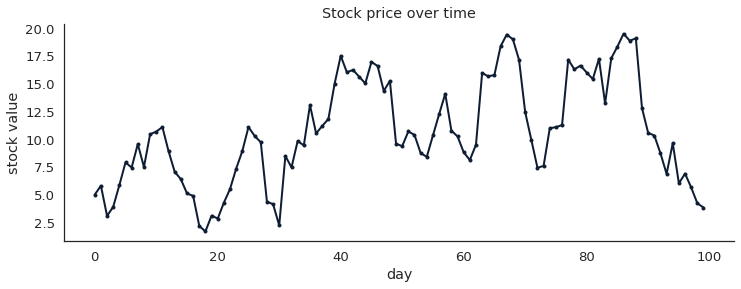

In [ ]:
''' Parameterize '''
sigma = 2
mu = 0
T = 100 # Number of days
x = np.zeros(T)
x[0] = 5 # Choose initial stock price

for t in range(1, T):  
  eps_t = stats.norm.rvs(mu, sigma)
  x[t] = x[t-1] + eps_t

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.set_title('Stock price over time')
ax.set_xlabel('day')
ax.set_ylabel('stock value')
ax.plot(x, '.-')
sns.despine()

#### 1.1.1 Mathematical analysis of stock market model

The previous equation gives the joint probability of all intermediate timepoints

\begin{align}
  p(x_{1:T} \mid x_0, \sigma^2) &= p(x_1, x_2, \ldots, x_T \mid x_0, \sigma^2) \\
  &=\prod_{t=1}^T p(x_t \mid x_0, x_1, \dots, x_{t-1} , \sigma^2)
\end{align}

If we assume that $ \mathbb{E}[x_t x_{t-j}] = x_0^2$ for all $|j| \geq 2$ $\color{green}{[1]}$, that is, the **Markov assumption** then the joint probability can be rewritten as

\begin{align}
  &= \prod_{t=1}^T p(x_{t+1} \mid x_t ,\sigma^2) 
\end{align}

To get the probability of the price at a future timepoint $\color{darkblue}{T}$: $p(x_{\color{darkblue}{T}} \mid \sigma^2, x_0)$, we integrate over all the intermediate variables

\begin{align}
  p(\color{darkblue}{x_T} \mid \sigma^2, x_0) &= 
  \int_{x_1 = - \infty}^{\infty} \ldots
  \int_{x_{T-1} = - \infty}^{\infty} 
  p(x_1, \dots , x_{T-1}, x_T \mid \sigma^2, x_0) \, dx_1 \dots , dx_{T-1}
\end{align}

In practice, computing this integral is not feasible. We can, however, compute the marginal probability in another way: by applying the transition model ($t \to t+1$) recursively:

\begin{align}
  x_T &= x_{T-1} + \epsilon_t \\
      &= x_{T-2} + \epsilon_{T-1} + \epsilon_t \\
      &= x_0 + \sum_{t=1}^k \epsilon_t
\end{align}

Thus, we can compute the value of the stock price at any future timepoint $T$ by taking the initial value $x_0$ and adding the sum of $T$ normally distributed values. This can be done because all $\epsilon$'s are independent. We have that

\begin{align}
  \mathbb{E}[x_t] &= \mathbb{E} \left[ x_0 + \sum_{i=1}^t \epsilon_i \right] \\
  &= x_0 + \sum_{i=1}^t \mathbb{E} [ \epsilon_i ]
\end{align}

and therefore,

\begin{align}
  p(x_T \mid \sigma, x_0) &= \mathcal{N}(x_T \mid x_0, T\sigma^2)
\end{align}

Our model predicts that the stock price mean stays constant, while the variance grows as a function of time. From this simple example we can understand that the further in time we want to go, the more uncertain we become about a prediction. 


--- 

$\color{green}{[1]}$ 
> \begin{align}
  \mathbb{E}[x_t x_{t-j}] &= \mathbb{E}[ (x_0 + \sum_{i=1}^t \epsilon_i) (x_0 + \sum_{i=1}^{t-j} \epsilon_i) ] \\
  &= \mathbb{E} [x_0^2 + x_0 \sum_{i=1}^{t-j} \epsilon_i + x_0 \sum_{i=1}^t \epsilon_i + \sum_{i=1}^{t-j} \sum_{i=1}^t \epsilon_i ]    \\
  &= x_0^2 + x_0 \sum_{i=1}^{t-j} \mathbb{E} [\epsilon_i] + x_0 \sum_{i=1}^{t} \mathbb{E} [\epsilon_i] + \sum_{i=1}^{t-j} \sum_{i=1}^t \mathbb{E}[\epsilon_i \epsilon_j] \\
  &= x_0^2 
\end{align}

when $\mathbb{E}[\epsilon_i]=0$, then the Markov assumption can be expressed as follows:
\begin{align}
  \mathbb{E} [\epsilon_i \epsilon_j] = 0 \text{ for all } |i, j| \geq 2
\end{align}

### 1.2 Example: Physical motion

Consider a simple modle of a dust particle with mass $m$ and a vertical position at each timepoint, $x(t)$. The dynamics of the particle is given by Newton's equation of motion

\begin{align}
  m \dot v(t) = F_t
\end{align}

with $\dot v(t) = \ddot x(t)$ is the acceleration of the particle. The total force acting on the particle is

\begin{align}
  F_t = -mg - a v(t) + \epsilon_t
\end{align}

with $g$ the g-force, $a$ the air resistance and $\epsilon_t$ the random gaussian force $\epsilon \sim \mathcal{N}(0, \sigma^2)$. This gives us the following systems of equations (SDE's):

\begin{align}
  m \dot v(t) &= -mg - a v(t) + \epsilon_t \\
  \dot x &= v(t)
\end{align}

since they include random local forces, the equations are known as Langevin equations. 

Using the Euler-Maruyama method we can discretize the equation into small time steps $dt$

\begin{align}
  v_{t+1} \mid v_t &\sim \mathcal{N}\left( v_t - (g + \frac{a}{m} v_t) dt, \frac{\sigma^2}{m} dt \right) \\
  x_{t+1} &= x_t + v(t) dt
\end{align}

Notice that the variance of this distribution increases with the size of the timestep $dt$. This is similar to the result in the previous example, where the variance of the random walk scales with the time $T$. The transition probabilities have the form

\begin{align}
  v_{t+1} \mid v_t \sim \mathcal{N}(\color{red}{\alpha v_t + \beta}, \color{blue}{\sigma^2 dt})
\end{align}

where we can clearly see that the mean at the next timestep is a linear regresssion (linear function) of the previous timestep. This form is called an **Autoregressive process** (AR for short).  

<center>
<img src="https://drive.google.com/uc?export=view&id=1Yr8i_uO-7OiYpPObcofQGXX8xgCDVZR7" alt="drawing" width="300"/>
</center>



In [ ]:
# ''' Parameterize '''
# T = 50 # Steps
# x = np.zeros(T)
# v = np.zeros(T)

# alpha = 0.05
# beta = 0.
# dt = 0.001
# sigma = 2

# # Initial position and velocity
# x[0] = 6
# v[0] = 2

# for t in range(T-1):
#   v[t+1] = stats.norm.rvs(loc=alpha * v[t] + beta, scale=sigma * dt)  
#   x[t+1] = x[t] + v[t] * dt

In [ ]:
# fig, axs = plt.subplots(1, 2, figsize=(14, 4))
# axs[0].set_title(r'Vertical position $x$')
# axs[0].plot(x, '.-')
# axs[1].set_title(r'Velocity $v$')
# axs[1].plot(v, '.-')
# sns.despine()

### 1.3 General time series models

> Variables are **i.i.d** (independently, identically distributed) when
<center><img src="https://drive.google.com/uc?export=view&id=1WmCO-69t4_v5AqEqN7BHGD_2KSJj8FsK" alt="drawing" width="300"/></center>
\begin{align}
  p(x_1, x_2, \dots, x_T) = \prod_{t=1}^T p(x_t)
\end{align}

In general, a variable $x_t$ depends on the values from _all_ the previous timepoints, which can be expressed as follows:

\begin{align}
  p(x_1, \ldots, x_T) = p(x_0) \prod^{T-1}_{t=0} p(x_{t+1} \mid x_0, \dots, x_t)
\end{align}

An M-th order **Markov model** is a timeseries model where each variable depends on the variable at M previous timepoints.

> A **First order Markov model** is described by
<center><img src="https://drive.google.com/uc?export=view&id=1LBpA8AMV3xjMKX1jCA1w34x74imWAhRt" alt="drawing" width="300"/></center>
\begin{align}
  p(x_1, x_2, \ldots, x_T) = p(x_1) \prod_{t=2}^T p(x_{t} \mid x_{t-1})
\end{align}

> A **M-th order Markov model** (M=2) is described by
<center><img src="https://drive.google.com/uc?export=view&id=1_k8JXFskgcWzlmk8_PvYhk4G6b2ePLy7" alt="drawing" width="300"/></center>
\begin{align}
  p(x_1, x_2, \ldots, x_T) = p(x_1) \prod_{t=2}^T p(x_{t} \mid x_{t-1}, x_{t-2}, \ldots, x_{\text{max}(t-M, 1)})
\end{align}

This is often summarized as _"the future is independent of the past given the present"_.


 

### 1.4 Structures of conditional independence

Recall that when variables $a$ and $b$ are statistically **independent**, we have that 
\begin{align}
  p(a, b) = p(a) p(b)
\end{align}
which implies that knowing $b$ doens't give us any information about the value of $a$:
\begin{align}
  p(a \mid b) = \frac{p(a, b)}{p(b)} = p(a)
\end{align}

Introducing a third variable $c$, we have that (provided that $a,b$ are independent)

\begin{align}
  p(a, b \mid c) = p(a \mid c) p(b \mid c)
\end{align}

A probabilistic model is defined by the structure of conditional independence. For example, if we have a first order Markov model, the variables of more than one step previous ($t-1$) do not provide useful information for the current state $x_t$. We make the following assumption

\begin{align}
  p(x_t \mid x_{t-1} \ldots x_n) = p(x_t \mid x_{t-1})
\end{align}



### 1.5 Statistical models and machine learning

It is common in Machine Learning to begin with simple, linear models and build up towards more complex models. Multiple linear regression models some variable of interest $\mathbf{y}$ as a linear combination of the features $\mathbf{X}$ plus some additive noise
\begin{align}
  \mathbf{y} = \mathbf{X} \boldsymbol{\beta} + \boldsymbol{\epsilon}
\end{align}
where
- $\mathbf{y}$ is 
- $\mathbf{X}$ is a matrix of features, our data
- $\boldsymbol{\beta}$ is a vector with parameters, the model
- $\boldsymbol{\epsilon}$ a vector with noise

a statistical model can be defined as 

\begin{align}
  p(\mathbf{y} \mid \boldsymbol{\beta} , \mathbf{X}, \mathbf{b}) &= \mathcal{N}(\mathbf{y} \mid \mathbf{X}\boldsymbol{\beta} + \mathbf{b}, \sigma^2)
\end{align}

In ML and DL, it is common to use more complex models that are able to learn the relationships from the data. For example, we can replace the linear regression model with a Deep Neural Network with $D$ layers. The parameters here are the weights that connect the nodes (learned) and the biases (constants)

\begin{align}
  p(\mathbf{y} \mid \mathbf{x}, \mathbf{W}, \mathbf{b}) = \mathcal{N} (\mathbf{y} \mid \text{DNN} (\mathbf{x}, \mathbf{W}, \mathbf{b}), \sigma^2)
\end{align}

which means we can pretty much construct any DNN, train the network and see how well the model learned the statistical regularities in the data. This approach, however, does have some major pitfalls

- **1.** The model may overfit the data, since the number of parameters is huge.
- **2.** The parameters do not have a physical meaning. Thus, such models are very hard to interpret. 

### 1.6 Combining machine learning with explicit modeling

In this course, we will integrate statistical and explicit modeling in a unified deep learning framework. We aim to use what we know about a system while keeping the machine learning flexibility to a minimum. 

In general, if we are uncertain about a component (we don't know a lot about it from previous literature etc.), we use a model that is flexible. Uncertain relationships can be learned from the data.  

## 2 Parameter estimation and maximum likelihood

Models are constructed by a set of parameters. In some cases, it is possible to obtain these parameter values from existing literature (such as the gravitational constant $g$ in section 1.2). However, this is infeasible for models with many parameters that do not really have a physical meaning - rather, the parameters are estimated from the data at hand.

How can we learn parameters from data? How do we know when a certain combination of parameter values is good or bad? There is a tool for this: the **maximum likelihood principle** (MLE). The general idea is to find parameters $\boldsymbol{\theta}$ that will maximize the probability of the data we actually observe.

Consider a set of datapoints measured from a real world system

\begin{align}
  D = \{ \mathbf{x}_1 , \ldots, \mathbf{x}_N \}
\end{align}

where we want to describe this data with the probabilistic model $p(\mathbf{x} \mid \boldsymbol{\theta})$. Assuming that the variables within each vector $\mathbf{x}_i$ are i.i.d. the likelihood function is

\begin{align}
  \mathcal{L}(\boldsymbol{\theta}) = \prod_{i=1}^N p(\mathbf{x}_i \mid \theta)
\end{align}

Thus, the likelihood for one set of parameter estimates given a fixed set of data y, is equal to the probability of the data given those (fixed) estimates. For computational reasons, we instead work with the sum of the natural log probabilities, and so deal with the **log likelihood**

\begin{align}
  \log \mathcal{L}(\boldsymbol{\theta}) = \sum_{i=1}^N \log [ p(\mathbf{x}_i \mid \boldsymbol{\theta})]
\end{align}

In words, we calculate a log likelihood for each observation and then sum them for the total likelihood for parameters $\boldsymbol{\theta}$. This is the loss function, the value we aim to minimize. Sometimes, you may see the maximum likelihood like this

\begin{align}
  \theta_{\text{MLE}} = \underset{\theta}{\text{arg max}} \,\, p(D \mid \theta)
\end{align}

---

#### Stock price max likelihood

Recall that the likelihood for the stock price was

\begin{align}
  p(\mathbf{x}_{1:T} ; \sigma^2, x_0) 
  &= \prod_{t=1}^T p(x_{t+1} \mid x_t ; \sigma^2) \\
\end{align}

so the log likelihood becomes

\begin{align}
  \log \mathcal{L} = \sum_{i=1}^N \sum_{t=1}^{T-1} \frac{(x^i_{t+1} - x_t^i)^2}{2 \sigma^2} + TN \log(2\pi \sigma^2) 
\end{align}

which gives us the maximum likelihood estimate...

### 2.1 Stochastic gradient descent

For differentiable probabilistic models we can minimize the loss by gradient descent as follows:

\begin{align}
  \theta_{t + 1} = \theta_t - \eta \nabla \log \mathcal{L}(\theta_t)
\end{align}

with $\eta$ as the learning rate. 

If the dataset is large, it is infeasible to compute the gradient over all data points. Instead, it is common to sub-sample a mini-batch of $B$ data points at each iteration and minimize the loss for this batch:

\begin{align}
  \theta_{t+1} = \theta_t - \eta \sum_{b=1}^B \nabla \log p(\mathbf{x}^b \mid \theta_t)
\end{align}

with $\eta$ being the learning rate. This method is called **Stochastic Gradient Descent** (SGD). Note that the stochasticity is a result of randomly sampling a subset of the data points over which the sum is computed. 

### 2.2 The Bayesian way

Bayesian statistics allows us to integrate prior knowledge (prior) with new information from the data (likelihood). 

We can derive Bayes' rule from the definition of conditional independence. The joint probability of the occurence of two dependent variables $a$ and $b$ is 

\begin{align}
  p(a, b) = \color{green}{p(a \mid b) p(b)}
\end{align}
so
\begin{align}
  p(a \mid b) = \frac{p(a, b)}{p(b)}
\end{align}

because the order of the joint probabilities doesn't matter we have that

\begin{align}
  p(a,b) &= p(b,a) \Leftrightarrow \\
  \color{green}{p(a \mid b) p(b)} &= \color{blue}{p(b \mid a) p(a)}  \\
  \Rightarrow \color{blue}{p(b, a)} &= \frac{\color{green}{p(a \mid b) p(b)}}{\color{blue}{p(a)}}
\end{align}

### 2.3 Maximum-a-posteriori

Computing the posterior may be hard or impossible due to large state spaces (high dimensional integrals). Sometimes, it can be sufficient to define a loss function where we minimize over the mode of the posterior distribution. This is called the **maximum-a-posterior** (MAP) loss

\begin{align}
  \mathcal{L}(\theta) = \sum_{i=1}^N \log p(\mathbf{x}^i \mid \theta)+ \log p(\theta)
\end{align}

The MAP is also described as

\begin{align}
  \theta_{\text{MAP}} = \underset{\theta}{\text{arg max}} \, \, p(D \mid \theta)
\end{align}


## 3 Inference in models with latent variables

We can often not directly observe the variables that we are interested in. Variables in a probabilistic model that are not directly observable are called **latent variables**. 

One example in Neuroscience is recording the activity of a set of neurons. We can't observe the activity directly, so have to use a measurement device (EEG, MEG, LFP, fMRI etc.). The neural activity is in this case your latent variable. It is still possible to perform inference in models with latent variables (more about that in the next lecture).

<center>
<img src="https://drive.google.com/uc?export=view&id=1F3KqFuVeS1wSSHs7NZErGzReUwC0VkII" alt="drawing" width="300"/>
</center>



```python
05.2021 | Daphne Cornelisse
```